### Treatment
In this section, I'm showing how I treated the data to prepare it for the machine learning models, some insights through data visualization are presented. I'm also showing some features of the powerful framework NLKT. But first, I'm showing the data treatment process, how the relevant variables are created, and the weekly data aggregation. Then, some data insides through summary tables, graphs, and word clouds.

In [8]:
#As usual, we need to import some librarys and frameworks. 
import pandas as pd
import numpy as np
from PIL import Image
import nltk
import os
import matplotlib.pyplot as plt
import glob
import snscrape.modules.twitter as sntwitter #twitter scrapper library
from nltk.sentiment import SentimentIntensityAnalyzer #sentiment analyzer
import seaborn as sns
import itertools
import pprint
from wordcloud import WordCloud
from tabulate import tabulate

I'm starting this section with the sentiment analysis of tweets. I'm using the pre-trained `SentimentIntensityAnalyzer()` to classify the tweets into positive, negative, or neutral sentiment. I'm doing this by creating a sentiment analysis function and applying it to the data collected. To start, we need to import weekly data and convert some columns to numeric to show the process. I'm using my birthday data as an example, like in [part 1](https://github.com/spacejao/Billboard-Hot100-and-Twitter-Engagement/blob/main/1%20-%20Getting%20the%20Data.ipynb).

In [11]:
data = pd.read_pickle('C:/Users/joaom/Desktop/data/data_2020/data_20200509.pkl')
data = data[data['text'].notnull()]
cols=['position', 'lastweek', 'weeks','favorites', 'retweets']
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce', axis=1)

We can now set up the `SentimentIntensityAnalyzer()` and create the sentiment function based on the tweet's compound attributed by the analyzer.  The Sentiment Analyzer from the `NLKT` library is based on VADER (Valence Aware Dictionary and sEntiment Reasoner). VADER is a powerful tool to analyze short sentences and text with slang or abbreviations, that is to say, VADER is very useful to classify tweets. The analyzer results are the probabilities of a text having positive, negative, or neutral sentiment.

In [12]:
#setting up the analyzer
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("")

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

Let's create a sentiment analyzer function and the `sentment` variable. 

In [33]:
#Creating the sentment funtion
def sentment(tweet: str) -> bool:      
    if sia.polarity_scores(tweet)["compound"]>0:
        return 'positive'
    elif sia.polarity_scores(tweet)["compound"]<0:
        return 'negative'
    elif sia.polarity_scores(tweet)["compound"]==0:
        return 'neutral'
#reating the sentment variable
data['sentment']=data.loc[:, 'text'].apply( lambda x: sentment(x))

The main goal of this project is to predict the changes in the position of a song on charts. To do this, we need to create two variables: a quantitative and a qualitative one. The first one will be used in a Regression Machine Learning model to predict how many positions a song has lost or earned in the week. The latter will be used in a Classification Machine Learning model to predict whether a song has gone up or down in the week. So let's create them.

In [32]:
data['variation']= data['lastweek'] - data['position']
def position_change(variation):
    if variation > 0:
        return 'up'
    elif variation <0:
        return 'down'
    elif variation==0:
        return 'same'
    else:
        return np.nan
data['change in position'] = data.loc[:,'variation'].apply(lambda x: position_change(x))
data.sample(5)

,position,music,artist,lastweek,peak,weeks,weekdate,datetime,usarname,text,favorites,retweets,sentment,variation,change in position
4294,63.0,i m ready,sam smith & demi lovato,36.0,36,2.0,2020-05-09,2020-05-08 16:24:52+00:00,kdrsplaylist,#nowplaying i m ready by sam smith &amp demi ...,0.0,0.0,positive,-27.0,down
3972,53.0,sum 2 prove,lil baby,60.0,16,16.0,2020-05-09,2020-05-06 23:16:58+00:00,RL1Radio,#nowplaying sum 2 prove by @lilbaby4pf #...,0.0,0.0,neutral,7.0,up
70,1.0,the scotts,the scotts travis scott & kid cudi,NaN,1,1.0,2020-05-09,2020-05-08 00:00:32+00:00,oku_papa,the scotts travis scott kid cudi - the scott...,0.0,0.0,neutral,NaN,NaN
5444,79.0,homemade,jake owen,81.0,39,14.0,2020-05-09,2020-05-07 13:08:13+00:00,spurradio,now playing on spurradio jake owen - homemade....,0.0,0.0,positive,2.0,up
660,7.0,don t start now,dua lipa,4.0,2,26.0,2020-05-09,2020-05-08 09:19:14+00:00,BIZwebradioPlay,06 19 dua lipa - don t start now #nowplaying ...,0.0,0.0,neutral,-3.0,down


### Visualization
Let's create a function that counts the sentiments of tweets of each song on Billboard's top_10 and bottom_10 of a given week and displays them in a pie and bar graph.

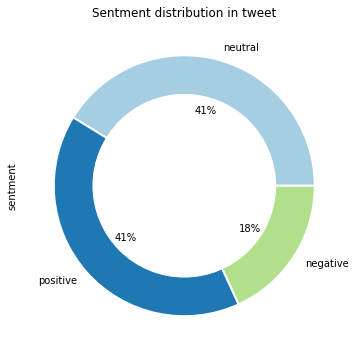

In [28]:
data['sentment'].value_counts().plot.pie(autopct = "%1.0f%%", # Mostrar o valor percentual
                                             colors =sns.color_palette("Paired",3),
                                             figsize=(6,6),
                                             wedgeprops = {"linewidth":2,"edgecolor":"white"})

my_circ = plt.Circle((0,0),.7,color = "white")
plt.gca().add_artist(my_circ)
plt.title("Sentment distribution in tweet")
plt.show()

With the pie graph above, we can check the proportion of the sentiments in all tweets. As we can see, positive and neutral tweets are the majority, with 41% of all tweets each. 

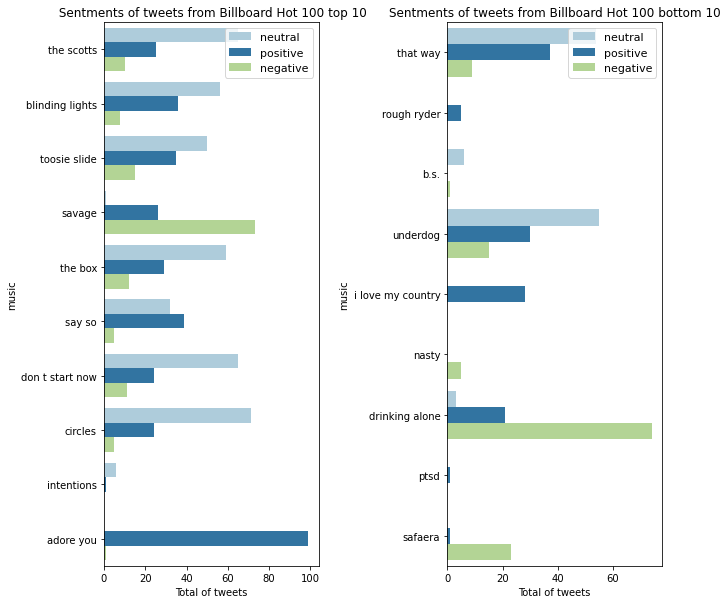

In [18]:

    top_10 = data[data['position']<11]
    bottom_10 = data[data['position']>90]
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    sns.countplot( y= top_10["music"],
                  hue=top_10["sentment"],
                  linewidth = 1,
                  palette=sns.color_palette("Paired"))

    plt.title(" Sentments of tweets from Billboard Hot 100 top 10")
    plt.legend(loc = "upper right" , prop = {"size" : 11})
    plt.xlabel("Total of tweets")
    
    plt.subplot(122)
    sns.countplot(y = bottom_10["music"],
                  hue=bottom_10["sentment"],
                  linewidth = 1,
                  palette=sns.color_palette("Paired"))

    plt.subplots_adjust(wspace = .6)
    plt.title("Sentments of tweets from Billboard Hot 100 bottom 10")
    plt.legend(loc = "upper right" , prop = {"size" : 11})
    plt.xlabel("Total of tweets")
    plt.show()
#tweets_bargraph(data)

The graph shows us songs in the top 10 seem to have more tweets than tracks in the bottom 10. Also, it shows us the amount of positive and neutral tweets in the top 10 songs is larger than the ones in the bottom 10. These might be evidence of how the data behaves. 

Using `NLTK`'s tokenize function, we can create a frequency table of the words which appear in tweets the most considering the English stopwords for any song on the charts.

In [77]:
def word_freq(data, music):
    words = []
    stopwords = nltk.corpus.stopwords.words("english")
    for i in data['text'][ data['music']==music].to_list():
        toke = nltk.word_tokenize(i)
        for word in token:
            if word.isalpha() == True:
                words.append(word)
    words=[w for w in words if w not in stopwords]
    fd = nltk.FreqDist(words)
    print(fd.tabulate(10))
word_freq(data,'come thru')

     usher       thru       come     summer     walker      https nowplaying         ft      clean listenlive 
       103        101         99         96         96         88         36         25         22         19 
None


As we can see, this table is not the most appealing way to show the word frequency. We can create a function that returns a word cloud to get the same information as the `nltk`  built-in word frequency table but more engagingly.

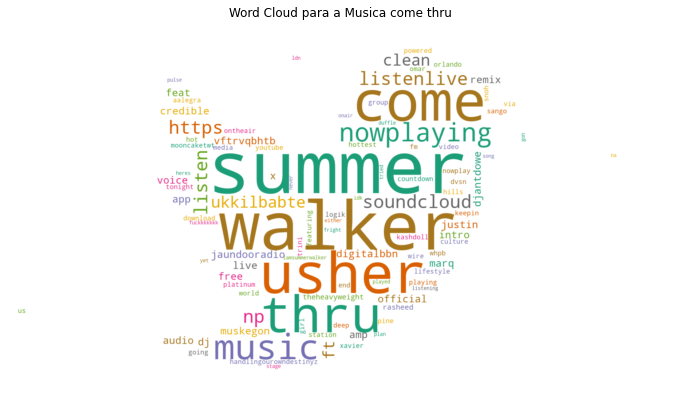

In [94]:
def music_WordCloud(data,music):
    words= []
    for i in data['text'][ data['music']==music].to_list():
        token = nltk.word_tokenize(i)
        for word in token:
            words.append(word)
    words = [ w for w in words if w.isalpha() == True]
    words= [ w for w in words if w not in stopwords]
    wrd = pd.DataFrame(words)
    wrd = wrd[0].unique()
    img = np.array(Image.open("C:\\Users\\joaom\\Desktop\\twitter.jpg"))
    wc = WordCloud(background_color="white",scale=2,mask=img,colormap="Dark2",max_words=100).generate(" ".join(wrd))
    fig = plt.figure(figsize=(12,12))
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud para a Musica {} ".format(music))
    plt.show()
music_WordCloud(data,'come thru')

### Aggregation

Long story short, I've created the function below to automate the process shown of treating and aggregating the data in the previous part of this section. 

In [5]:
def get_agg_data(year):
    path = r'C:/Users/joaom/Desktop/data/data_{}/'.format(year)               
    all_files = glob.glob(os.path.join(path, "*.pkl"))     
    for file in all_files:   
        data = pd.read_pickle(file)
        cols=['position', 'lastweek', 'weeks','favorites', 'retweets']
        data = data[data['text'].notnull()]
    
        data['sentment'] = data.loc[:, 'text'].apply( lambda x: sentment(x))
        data[cols] = data[cols].apply(pd.to_numeric, errors='coerce', axis=1)
        data['variation']= data['lastweek'] -  data['position']
        def position_change(variation):
            if variation > 0:
                return 'up'
            elif variation <0:
                return 'down'
            elif variation==0:
                return 'same'
            else:
                return np.nan
        data['change in position'] = data.loc[:,'variation'].apply(lambda x: position_change(x))
        data
        agg_data1 = data.groupby(['weekdate',
                                  'artist', 
                                  'music', 
                                  'position',
                                   'weeks']).aggregate({'retweets': 'sum',
                                                          'favorites': 'sum', 
                                                          'sentment':'count',
                                                          'lastweek':'first',
                                                          'variation':'first',
                                                          'change in position':'first'}).reset_index()
        agg_data = data.groupby(['weekdate',
                                'artist',
                                'music',
                                'position',
                                'weeks',  
                                'sentment']).aggregate({'retweets': 'sum', 
                                                        'favorites': 'sum', 
                                                        'sentment':'count' ,
                                                        'lastweek':'first',
                                                        'variation':'first',
                                                        'change in position':'first'}).unstack().reset_index()
        agg_data1['negative']= agg_data['sentment'].negative
        agg_data1['positive']= agg_data['sentment'].positive
        agg_data1['neutral'] = agg_data['sentment'].neutral
        date= agg_data1['weekdate'].values[1]
        agg_data1.to_pickle('C:/Users/joaom/Desktop/data/agg_data/agg_data_'+ 
                            ''.join(pd.to_datetime(date).strftime('%Y-%m-%d').split('-'))+'.pkl')

Using a loop to get the historical data aggregated as shown below, we can pass to the following analysis: the songs with the most number of tweets, retweets, and favorites; as well as the song which stayed the most on charts; and songs with the most number of positive, negative or neutral tweets. 

In [ ]:
for i in range(2008,2022):
    get_agg_data(i)
path = r'C:/Users/joaom/Desktop/data/agg_data/'             
all_files = glob.glob(os.path.join(path, "*.pkl"))     
df_from_each_file = (pd.read_pickle(f) for f in all_files)
hist_agg_data = pd.concat(df_from_each_file, ignore_index=True)
hist_agg_data['weekdate'] = hist_agg_data.loc[:,'weekdate'].apply(pd.to_datetime)

The table below shows the songs with the most retweets, favorites, positives tweets, negative tweets, and neutral tweets. As we can see 'Blinding Lights' by the Weeknd was a big success staying on charts for 90 weeks, it also was the song with the most favorites, retweets, and the number of tweets. While  'I gotta feeling' by The Black Eyed Peas was the song with the most positive tweets,  "I'm yours" by James Blunt was the song with the most negative tweets. Last but maybe least, "If I die young" by The Band Perry was the song with the most negative tweets. 

In [10]:
x = hist_agg_data.groupby(['music', 'artist','weekdate','weeks','position']).agg({ 'favorites': 'sum', 'retweets': 'sum', 'positive': 'sum', 'negative': 'sum', 'neutral' : 'sum', 'sentment': 'sum'}).reset_index().set_index('weekdate').rename(columns={'sentment':'tweets'}).sort_index()
z=x.groupby([(x.index.year), 'music', 'artist']).agg({'weeks':'max', 'position' :'min','favorites':'sum','retweets':'sum','tweets':'sum', 'positive':'sum', 'negative':'sum', 'neutral':'sum'})
y = z.groupby(['music', 'artist']).agg({'weeks':'max', 'position' :'min','favorites':'sum','retweets':'sum','tweets':'sum','positive':'sum', 'negative':'sum', 'neutral':'sum', }).reset_index()

table= [['Tweets',y.at[y['tweets'].argmax(), 'music'],y.at[y['tweets'].argmax(), 'artist'],y.at[y['tweets'].argmax(), 'tweets']],
        ['Favorites',y.at[y['favorites'].argmax(), 'music'],y.at[y['favorites'].argmax(), 'artist'],y.at[y['favorites'].argmax(), 'favorites']],
        ['Weeks', y.at[y['weeks'].argmax(), 'music'],y.at[y['weeks'].argmax(), 'artist'], y.at[y['weeks'].argmax(), 'weeks']],
        ['Retweets', y.at[y['retweets'].argmax(), 'music'], y.at[y['retweets'].argmax(), 'artist'], y.at[y['retweets'].argmax(), 'retweets']],
        ['Positives tweets', y.at[y['positive'].argmax(), 'music'],y.at[y['positive'].argmax(), 'artist'], y.at[y['positive'].argmax(), 'positive']],
        ['Negative tweets', y.at[y['negative'].argmax(), 'music'], y.at[y['negative'].argmax(), 'artist'], y.at[y['negative'].argmax(), 'negative']],
        ['Neutral tweets', y.at[y['neutral'].argmax(), 'music'], y.at[y['neutral'].argmax(), 'artist'], y.at[y['neutral'].argmax(), 'neutral']]]
print(tabulate(table, headers=['Max of', 'Music', 'Artist','Number of']))


Max of            Music            Artist                 Number of
----------------  ---------------  -------------------  -----------
Tweets            blinding lights  the weeknd                  9000
Favorites         blinding lights  the weeknd                548192
Weeks             blinding lights  the weeknd                    90
Retweets          blinding lights  the weeknd                 99773
Positives tweets  i gotta feeling  the black eyed peas         5355
Negative tweets   if i die young   the band perry              4859
Neutral tweets    i m yours        jason mraz                  6237


We can summarize the yearly aggregated dataframe in the following table. With this, we can see the main statistics of all variables in the data.

In [46]:
y.describe().drop(['weeks', 'position'], axis=1)

,favorites,retweets,tweets,positive,negative,neutral,%neg,%pos,%neu
count,6354.000000,6354.000000,6354.000000,6354.000000,6354.000000,6354.000000,6354.000000,6354.000000,6354.000000
mean,3428.941926,755.167296,758.793988,326.172490,114.626692,317.994806,17.842364,42.951294,39.206341
std,15941.613284,3300.340256,1063.434245,616.516746,361.337705,618.681687,29.337211,34.103796,34.304968
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,56.000000,13.000000,2.000000,2.000000,1.041667,17.391304,0.705882
50%,79.000000,39.000000,200.000000,66.000000,12.000000,33.000000,4.857143,31.000000,46.000000
75%,1049.500000,309.000000,1300.000000,359.000000,67.000000,265.750000,14.000000,76.835227,69.387755
max,548192.000000,99773.000000,9000.000000,5355.000000,4859.000000,6237.000000,100.000000,100.000000,100.000000


Another relevant statistic we must check is the correlation between the variables. Instead of creating a table full of numbers, we can display the correlation matrix in a figure as a heatmap. 

Text(0.5, 1.0, 'Correlation Matrix')

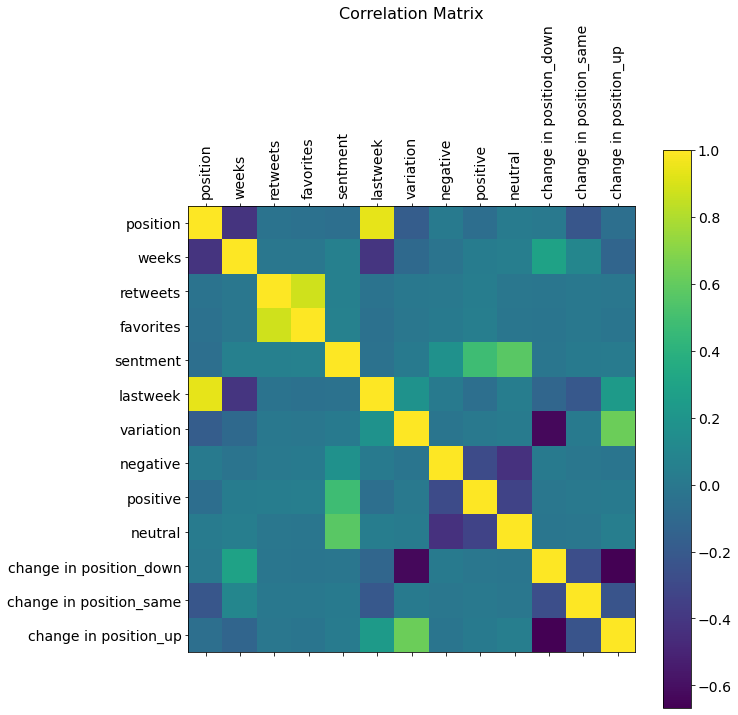

In [9]:
f = plt.figure(figsize=(10, 10))
plt.matshow(pd.get_dummies(hist_agg_data, columns=['change in position']).corr(), fignum=f.number)
plt.xticks(range(pd.get_dummies(hist_agg_data, columns=['change in position']).select_dtypes(['number']).shape[1]), pd.get_dummies(hist_agg_data, columns=['change in position']).select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(pd.get_dummies(hist_agg_data, columns=['change in position']).select_dtypes(['number']).shape[1]), pd.get_dummies(hist_agg_data, columns=['change in position']).select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)